# Multiphysic model and controller synthesis


The objectives of this step are :
- understand the operating principle of a reaction wheel and its action on a satellite
- model the dynamic behavior of a reaction wheel/satellite assembly.
- synthesize a control law for an ideal system
- analyze imperfections that may influence performance

These dynamic models can help with the design of the electromechanical part and control part of this system.


## Global view of the systam

Nanosatellites, such as CubeSats, employ various technologies for attitude control. Reaction wheels are common actuators providing precise control through momentum exchange. A reaction wheel consists of several key components:
- **Flywheel:** A disk or wheel with significant mass, designed to spin at high speeds to generate angular momentum for controlling the satellite's orientation.
- **Electric Motor:** Typically a brushless DC motor, it drives the flywheel to spin at varying speeds in response to control commands. *In our cas a DC motor simpler to control.*
- **Motor Controller:** An electronic circuit that regulates the motor's torque, speed and direction, allowing precise control of the flywheel's rotation. *In our case a DC/DC chopper.*
- **Sensors:** Devices such as gyrometer and magnetometer that monitor the cubesat rotational speed and position, providing feedback to the control system for precise adjustments. *In our case a magnetometer.*  

These components work together to enable the reaction wheel to effectively manage the satellite's attitude by altering its rotational velocity. The Modelica diagram below describes how this system works.

![ModelicaSimple](./Image/ModelicaSimple.png)

> **Question:** On previous Figure, circle and define the following elements: Electric motor, Battery, Chopper, Satellite structure, Inertia wheel, Position sensor, Controller 


## Electric motor

Nous allons analyser dans un 1er temps la dynamique du moteur et de son volant d'inertie. Nous négligerons ici couples de frottement sec (non linéaires). Le moteur sera supposé fixe. La période d'échantillonnage du contrôleur sera d'environ 100 ms. 

The system to be analysed has the following characteristics:  

| Parameter  | Value  | Unit |  
|:-:|:-:|:-:|  
| Resistance $R$ |   18       |  $\Omega$ |  
| Inductance $L$ | $4.6$ |   $mH$ |   
| Torque constante $K$ |$1.6.10^{-2}$| $N.m/A$ |  
| Motor inertia $J$ | $3.10^{-6}$| $kg.m²$ |  
| Flywhell inertia $J$ | $1.10^{-5}$| $kg.m²$ |  

> **Question 1:** Give the differential equations expressing : the motor current $i(t)$ as a function of input voltage $u(t)$ (electrical equation), the rotor speed $\Omega(t)$ as function of the current $i(t)$ (mechanical equation). 

:::{dropdown} Solution
**Electrical equation:** $u(t)= Ri(t) + L\frac{di(t)}{dt} + e(t)$  
with $e(t)= K\Omega(t) $

**Mechanical equation:** $ J \frac{d\Omega}{dt} = Ki(t) $  
with $J= J_{motor} + J_{flywheel}$
:::


In [26]:
# Parameters

#--- Motor Constants ---
Km = 1.6e-2 #[N.m/A] Motor Constant
Lm = 4.6e-3 #[H] Motor Inductance
Rm = 18 #[Ohms] Motor resistance
Jm = 3e-6 #[kg.m²] Motor Inertia

#--- Flywheel Constants ---
Jf = 1e-5  #[kg.m²] Flywheel Inertias
J=Jf+Jm #[kg.m²] Flywheel and rotor Inertias

> **Question 2:** By comparing electrical time constant to sampling time, explain how to simply this set of equations. Give the global transfer function between rotor speed and input voltage $U$. 

:::{dropdown} Solution
Electrical time constant is $L/R$ and is small compare to sampling time: we can negelct the term $L\frac{di(t)}{dt}$  
The two equations become:  
**Electrical equation:** $u(t)= Ri(t) + K\Omega(t)$  
**Mechanical equation:** $ J \frac{d\Omega}{dt} = Ki(t) $   
After Laplace transform:  
$U(p) = RI(p) + K.\Omega(p)$  
$J p\Omega(p) = KI(p)$   
and manipulation:  
$U(p) = \frac{RJ}{K}p\Omega(p) + K\Omega(p)$   
We get the transfer function:  
$ \frac{\Omega(p)}{U(p)} = \frac{1/K}{1+\frac{RJ}{K^2}p} $
:::

> **Question 3:** Compare the time response of the transfer function with this unit step simulation. 

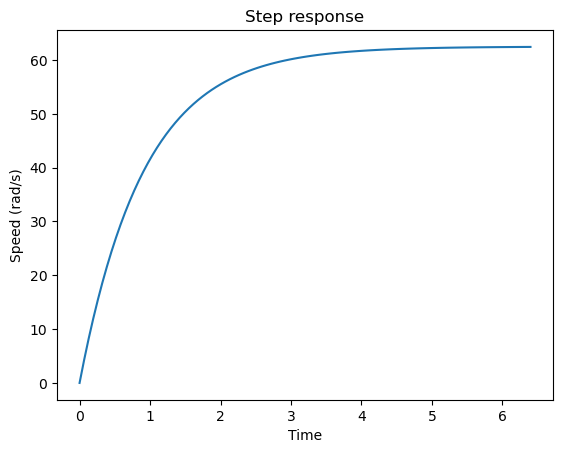

In [27]:
import numpy as np                  # basic package for numerical calculations
import matplotlib.pyplot as plt     # plotting package
from scipy.signal import step       # Import from scipy of the step response

# First order step response
num = [1/Km]
den = [Rm*J/Km**2, 1]
t, y = step(system=(num, den))

plt.plot(t,y)
plt.title('Step response')
plt.xlabel('Time')
plt.ylabel('Speed (rad/s)')
plt.show()


## Linear dynamic model

The goal now is to analyze the complete behavior of the motor/flywheel system linked to the satellite. We will assume here that the satellite is only free to move on one axis of rotation and without friction.
 
> **Question 1:** Explain how to adapt mechanical equation into a set of two equation : one for the motor speed $Ω_m$ and one for the satellite speed $Ω_s$ of the sateliite. Pay close attention to the action/reaction principle on torque at the electric motor (see fiugre below). We will assume both speed positive for a positive current in the motor. 

![Reaction Torque](./Image/ReactionTorque.png)

> **Questions 2:** Explain hot to adapt the electrical equation in order to take into account these speeds $Ω_m$ and $Ω_s$. 

> **Question 3:** Orient these equations so as to obtain the angular position $θ_s$  of the satellite as a function of the supply voltage. Expression the transfer function $\frac{θ_s(p)}{U(p)}$. 

## Controller synthesis

The figure below represents the body diagram of the system relating the voltage on the motor (input) to the position of the satellite (output).

> **Question 1:** Justify the choice of a PD corrector to achieve position control. 

Open loop bode diagram (no PI, wih sensor): 


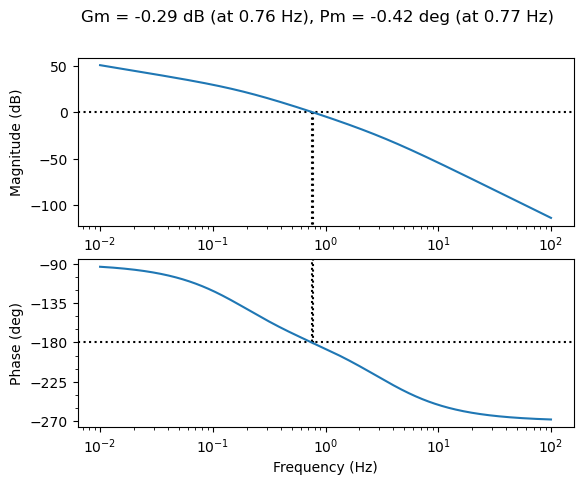

In [28]:
import control.matlab as ctl # for bode plotting

#--- Satelite Constants ---
Js = 4e-4  #[kg.m²] Satelite Inertia

#--- Sensor Constants ---
fs=10 #[Hz] acquisition frequency
ts=1/fs
tm=ts/2 # [s] equivalent time constant of the sensor (magnetometer)

#Battery
Ubat=11.1 # [V] Battery voltage

# Transfer Function

# --- Paramètres ----
G=Ubat*J/(Km*(J+Js))
Tau= Rm*Js / (Km **2 * (1+(Js/J)))

# Transfer Function
Satellite = ctl.tf([G/Tau],[1,1/Tau,0])
Sensor = ctl.tf([1],[tm,1])

# Bode diagram
print("Open loop bode diagram (no PI, wih sensor): ")
hbo = Satellite*Sensor
mag,phase,omega = control.bode(hbo, margins = True, Hz=True)

> **Question 2:** Analyze the code below and explain how the PD corrector is implemented.

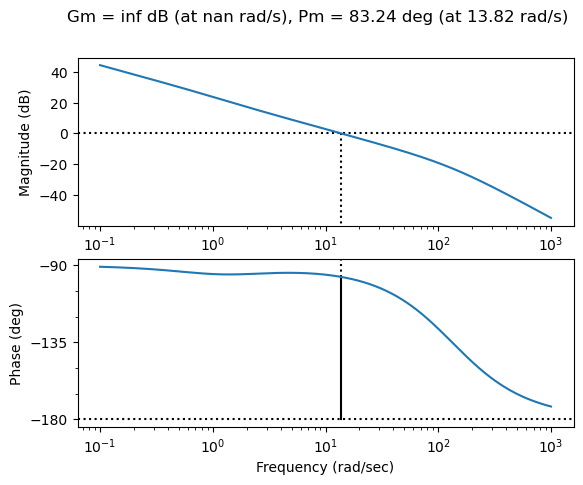

In [30]:
# PD corrector
tau_d=0.75
K=0.75
N=100

Cpd = ctl.tf([K*tau_d, K ],[tau_d/N,1])

# Global system: open loop
hbo_ass =Satellite*Cpd
# ode plot
mag, phase, omega= ctl.bode(hbo_ass, plot=True, Hz=False, margins=True)



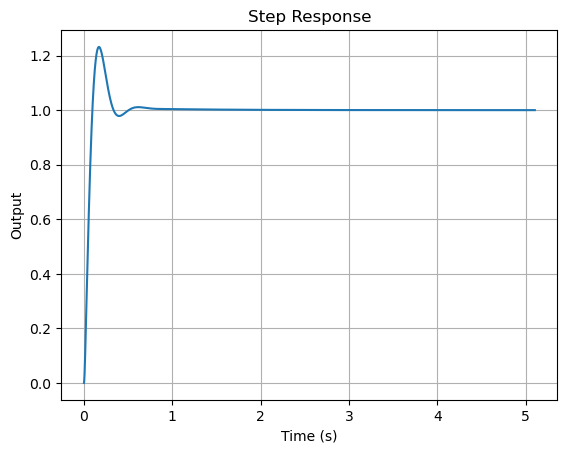

In [31]:
# Time response: close loop
hbf_ass = ctl.feedback(Cpd*Satellite,Sensor,-1)
t, y = ctl.step(hbf_ass)

plt.plot(y, t)
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Step Response')
plt.grid(True)
plt.show()



## Modelica model 

### Model description

You can download the Modelica models [here](./modelica/AttitudeControlCubeSatTP.mo). An example of model is represented below. 

![Modelica Full](./Image/ModelicaFull.PNG)

This model comprises a setpoint (expressed in radians) followed by a proportional-derivative (PD) controller.

The “TF” block represents the chopper and acts as a voltage converter, transforming a source with a fixed voltage level - in this case, the battery - into a variable voltage. The battery supplies a constant voltage of 11.1 V, while the converter's input control adjusts the output voltage between -11.1 V and 11.1 V.

The motor section models a DC motor. It includes key elements such as resistance, inductance and electromotive force (EMF), which convert electrical energy into rotary motion, as well as a friction torque simulating mechanical losses.

The CubeSat strcuture is represented by an associated inertia. Depending on the model, this inertia may be associated with a dry friction torque simulating the resistance of the swivel holding the CubeSat to the model. 

Finally, sampler blocks are used to sample the continuous signal, simulating sensor measurements and control code execution time. In our case, the sampling frequency is 100 ms.


### Simulation results

The PID corrector is initialized with the previously calculated parameters. Here is the simulation result:
- without dry friction (not taken into account in previous calculations)
- with dry friction 

![Simulation results](./Image/ResultatSimuPD.png)

We'll stick to this design with our low-cost model.

> **Question:** How could we improve the lab setup if we had more means at our disposal to limit these imperfections? 